In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import h5py
import argparse

from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from skimage.transform import resize

In [0]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd '/content/gdrive/My Drive/Colab Notebooks/Segmentation/Data'

/content/gdrive/My Drive/Colab Notebooks/Segmentation/Data


<h2> 1. Data Preprocessing

In [0]:
hf = h5py.File('Brain_classification.h5', 'r')
[key for key in hf.keys()]

['imgs', 'labels']

In [0]:
imgs = hf.get('imgs')
labels = hf.get('labels')

In [0]:
imgs.shape

(3929, 256, 256)

In [0]:
labels.shape

(3929,)

In [0]:
img_rows = 96
img_cols = 96

def imgs_resize(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.float32)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_rows, img_cols), preserve_range=True)

    return imgs_p

In [0]:
def Z_score_norm_imgs(imgs):
  imgs = imgs.astype('float32')
  mean = np.mean(imgs)
  std = np.std(imgs)
  
  imgs -= mean
  imgs /= std
  
  return imgs

<h3> # Min-max normalization을 만들어보세요!

In [0]:
def Min_max_norm_imgs(imgs):
  imgs = imgs.astype('float32')
  Min = np.min(imgs)
  Max = np.max(imgs)
  
  imgs -= Min
  imgs /= (Max-Min)
  
  return imgs

In [0]:
#Images resize
imgs = imgs_resize(imgs)
labels = np.array(labels, dtype=np.float32)

In [0]:
#Images normalization
imgs_MM = Min_max_norm_imgs(imgs)

In [0]:
#Images normalization
imgs_N = Z_score_norm_imgs(imgs)

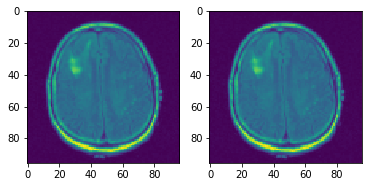

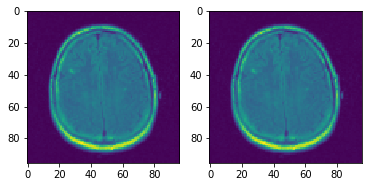

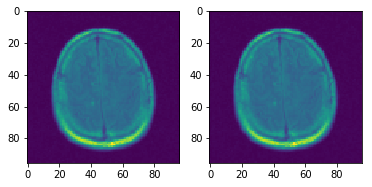

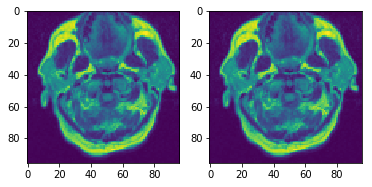

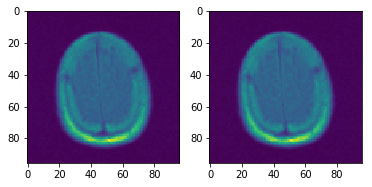

In [0]:
for i in range(8,13):
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(imgs_MM[i])
  plt.subplot(1,2,2)
  plt.imshow(imgs_N[i])

In [0]:
for i in range(8,13):
  print(labels[i])

1.0
1.0
0.0
0.0
0.0


In [0]:
# Expand Dims
imgs = imgs_N[..., np.newaxis]
labels = labels[..., np.newaxis]

In [0]:
# Channel first
imgs = imgs.transpose(0, 3, 1, 2) # B x C x H x W format

In [0]:
# Numpy to tensor
imgs = torch.from_numpy(imgs)
labels = torch.from_numpy(labels)

In [0]:
imgs_train = imgs[:3000]
labels_train = labels[:3000]

imgs_val = imgs[3000:3400]
labels_val = labels[3000:3400]

imgs_test = imgs[3400:]
labels_test = labels[3400:]

In [0]:
imgs_train = TensorDataset(imgs_train, labels_train)
imgs_val = TensorDataset(imgs_val, labels_val)
imgs_test = TensorDataset(imgs_test, labels_test)

<h2> 2. Model Architecture

<h3> # 본인만의 네트워크를 만들어 보세요!

In [0]:
# from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py

cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}        

In [0]:
# Sequential
class CNN(nn.Module):
    
    def __init__(self, model_mode, in_channels): # 생성자로 부터 각 parameters를 받아옮
        super(CNN, self).__init__()
        
        self.layers = self.make_layers(model_mode, in_channels)
        self.classifier = nn.Sequential(nn.Linear(4608, 512), nn.ReLU(), nn.Linear(512, 1), nn.Sigmoid())
        
    # List <- Sequential
    def make_layers(self, model_mode, in_channels):
        layers = []
        for x in cfg[model_mode]:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size = 2, stride = 2)]
            else :
                layers += [nn.Conv2d(in_channels=in_channels, out_channels = x, kernel_size = 3, stride=1, padding=1)]
                layers += [nn.BatchNorm2d(x)]
                layers += [nn.ReLU()]
                in_channels = x
        return nn.Sequential(*layers) # * python 문법 : 하나씩 넣어줌.
    
    def forward(self, x):
        x = self.layers(x) # sequential : 하나가 통째로 모델이 되어서
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x

In [0]:
# ModuleList
class CNN(nn.Module):
    
    def __init__(self, model_mode, in_channels):
        super(CNN, self).__init__()
        
        self.layers = self.make_layers(model_mode, in_channels)
        self.classifier = nn.Sequential(nn.Linear(4608, 512), nn.ReLU(), nn.Linear(512, 1), nn.Sigmoid())
    
    # ModuleList <- append
    def make_layers(self, model_mode, in_channels):
        layers = nn.ModuleList()
        for x in cfg[model_mode]:
            if x == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else :
                layers.append(nn.Conv2d(in_channels=in_channels, out_channels=x, kernel_size=3, stride=1, padding=1))
                layers.append(nn.BatchNorm2d(x))
                layers.append(nn.ReLU())
                in_channels = x               
        return layers
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [0]:
def dimension_check():
    net = CNN('vgg16', 1)
    x = torch.randn(32, 1, 96, 96)
    y = net(x)
    print(y.size())

In [0]:
dimension_check()

torch.Size([32, 1])


In [0]:
# Parameters setting
parse = argparse.ArgumentParser()
args = parse.parse_args("")

args.device  = 'cuda' if torch.cuda.is_available() else 'cpu'
args.act = 'relu'
args.optim = 'Adam'
args.lr = 0.001
args.epoch = 30
args.train_batch_size = 32
args.val_batch_size = 32
args.test_batch_size = 32

#model
model = CNN('vgg16', 1).to(args.device)

#optimization
if args.optim == 'Adam':
    op = optim.Adam(model.parameters(), lr=args.lr)
elif args.optim == 'RMSprop':
    op = optim.RMSprop(model.parameters(), lr=args.lr)
else:
    raise ValueError('Optimiser Error!!')

#Loss
criterion = nn.BCELoss()

parts = {'train':imgs_train, 'val':imgs_val}

<h2> 3. Train & Evaluation Functions

In [0]:
def train(model, op, criterion, args):
    for epoch in range(args.epoch):
        for part in parts:
            loss_sum = 0
            if part == 'train':
                loader = torch.utils.data.DataLoader(parts['train'], batch_size=args.train_batch_size, shuffle = True, num_workers=2)
                model.train()
            else:
                loader = torch.utils.data.DataLoader(parts['val'], batch_size=args.val_batch_size, shuffle = True, num_workers=2)
                model.eval()
                
            for Inputs, Labels in loader:
                Inputs = Variable(Inputs.to(args.device))
                Labels = Variable(Labels.to(args.device))
                
                # 1. clear the gradients of all optimized variables
                op.zero_grad() 
                
                # 2. forward pass
                Outputs = model(Inputs)
                
                # 3. calculate the loss
                loss = criterion(Outputs, Labels)
                loss_sum += loss.item() # 1개의 원소를 가진 Tensor를 Python의 Scalar로 만들 때는 .item()함수를 사용한다.
                   
                if part == 'train':
                  
                    # 4. backward pass
                    loss.backward()
                    
                    # 5. parameter update
                    op.step()
            print('{} - epoch : {}, loss : {:2.2f}'.format(part, epoch+1, loss_sum/len(loader)))

In [0]:
train(model, op, criterion, args)

train - epoch : 1, loss : 0.66
val - epoch : 1, loss : 1.32
train - epoch : 2, loss : 0.46
val - epoch : 2, loss : 0.49
train - epoch : 3, loss : 0.44
val - epoch : 3, loss : 0.48
train - epoch : 4, loss : 0.43
val - epoch : 4, loss : 0.44
train - epoch : 5, loss : 0.42
val - epoch : 5, loss : 0.45
train - epoch : 6, loss : 0.42
val - epoch : 6, loss : 0.70
train - epoch : 7, loss : 0.41
val - epoch : 7, loss : 0.47
train - epoch : 8, loss : 0.39
val - epoch : 8, loss : 0.95
train - epoch : 9, loss : 0.37
val - epoch : 9, loss : 0.38
train - epoch : 10, loss : 0.37
val - epoch : 10, loss : 0.42
train - epoch : 11, loss : 0.33
val - epoch : 11, loss : 0.29
train - epoch : 12, loss : 0.28
val - epoch : 12, loss : 0.27
train - epoch : 13, loss : 0.28
val - epoch : 13, loss : 0.23
train - epoch : 14, loss : 0.26
val - epoch : 14, loss : 0.25
train - epoch : 15, loss : 0.25
val - epoch : 15, loss : 0.46
train - epoch : 16, loss : 0.24
val - epoch : 16, loss : 0.21
train - epoch : 17, loss :

In [0]:
# save
Path = './weight_classification_v1.pt'
torch.save(model.state_dict(), Path)

In [0]:
#load
model = CNN('vgg16', 1).to(args.device)
model.load_state_dict(torch.load("weight_classification_v1.pt"))

<All keys matched successfully>

In [0]:
Results = []
Labels = []
testloader = torch.utils.data.DataLoader(imgs_test, batch_size=args.test_batch_size, shuffle = False, num_workers=2)
model.eval()

# predict all data from testloader
with torch.no_grad():
  for data in testloader:
    images, labels = data
    images = images.to(args.device)
    labels = labels.to(args.device)
    
    outputs = model(images)
    Results.extend(outputs.cpu().numpy().transpose(1,0)[0])
    Labels.extend(labels.cpu().numpy().transpose(1,0)[0])

<h3> 3.1. Receiver Operating Characteristic curve

In [0]:
# Expand Dims
score_values = np.array(Results)[..., np.newaxis]
labels = np.array(Labels)[..., np.newaxis]

In [0]:
# roc curve tools
from sklearn.metrics import roc_curve, auc

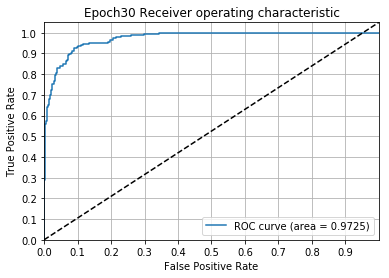

In [0]:
fpr, tpr, _ = roc_curve(labels,score_values)
roc_auc = auc(fpr,tpr)
    
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
ax.plot([0, 1], [0, 1.05], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xticks(np.arange(0.0, 1.0, 0.1))
ax.set_yticks(np.arange(0.0, 1.05, 0.1))
ax.grid()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Epoch30 Receiver operating characteristic')
ax.legend(loc="lower right")

<h3> 3.2. Confusion Matrix


In [0]:
#confusion matrix
y_true = labels
y_pred = [1 if pred>0.5else 0 for pred in score_values]

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

figsize=(10,10)
cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)

In [0]:
tmp = np.zeros((2, 2))
tmp[0][0] = cm[0][0]/(cm[0][0]+cm[0][1])
tmp[0][1] = cm[0][1]/(cm[0][0]+cm[0][1])
tmp[1][0] = cm[1][0]/(cm[1][0]+cm[1][1])
tmp[1][1] = cm[1][1]/(cm[1][0]+cm[1][1])
accuracy=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Accuracy : {:2.2}".format(accuracy))

Accuracy : 0.89


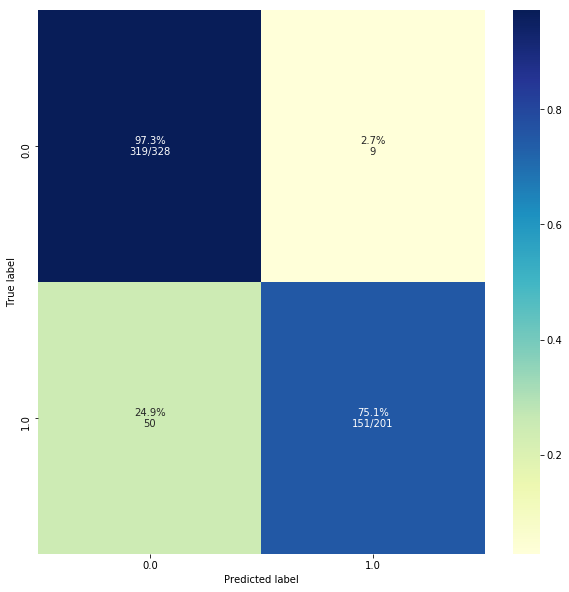

In [0]:
tmp = pd.DataFrame(tmp, index=np.unique(y_true), columns=np.unique(y_true))
tmp.index.name = 'True label'
tmp.columns.name = 'Predicted label'
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(tmp, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)